### Tutorial : https://www.youtube.com/watch?v=Lakz2MoHy6o

In [3]:
import numpy as np
# from layer import Layer
from scipy import signal
import tensorflow_datasets as tfds
from pathlib import Path
import os
import shutil
import tensorflow as tf

import matplotlib.pyplot as plt

In [4]:
class Layer():
  def __init__(self):
    self.input
    self.output
  
  def forward(self, input):
    pass

  def backward(self, output_grad, learning_rate):
    pass

  
class Activation(Layer):
  def __init__(self, activation, activation_prime):
    self.activation = activation
    self.activation_prime = activation_prime
  
  def forward(self, input):
    self.input = input
    return self.activation(self.input)

  def backward(self, output_grad, learning_rate):
    return np.multiply(output_grad, self.activation_prime(self.input))


In [5]:
class Dense(Layer):
  def __init__(self, input_size, output_size):
    self.weights = np.random.randn(output_size, input_size)
    self.bias = np.random.randn(output_size, 1)
  
  def forward(self, input):
    self.input = input
    return np.dot(self.weights ,self.input) + self.bias

  def backward(self, output_grad, learning_rate):
    weights_grad = np.dot(output_grad, self.input.T)
    self.weights -= learning_rate * weights_grad 
    self.bias -= learning_rate * output_grad
    return np.dot(self.weights.T, output_grad)




In [6]:
class Conv2D(Layer):
  def __init__(self, input_shape, kernel_size, depth):
    #input shape must be (3,x,x) for color image, or (x,x) for black and white ( like MNIST)
    input_depth, input_width, input_height  = input_shape
    self.depth = depth
    self.input_shape = input_shape
    self.input_depth = input_depth
    self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
    self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
    #init kernel with random
    self.kernels = np.random.randn(*self.kernels_shape)
    #biases has the same dimension with output
    self.biases = np.random.randn(*self.output_shape)

  def forward(self, input):
    #Formula: 
    #Y_i = B_i + sum ( X_j * K_ij) [ j = 1 --> n, i = 1 --> depth]
    self.input = input
    self.output = np.copy(self.biases)
    for i in range(self.depth):
      for j in range(self.input_depth):
        self.output[i] += signal.correlate2d(self.input[j], self.kernels[i,j], "valid")
    return self.output

  def backward(self, output_gradient, learning_rate):
    #e.g : kernels shape = (depth, 3 for color channel, 3 for kernel size ,3 for kernel size)
    kernels_gradient = np.zeros(self.kernels_shape)
    #e.g: inputshape = (channels, height, width)
    input_gradient = np.zeros(self.input_shape)
    #calculate the 3 components ofr gradient descend
    for i in range(self.depth):
      for j in range(self.input_depth):
        kernels_gradient[i,j] = signal.correlate2d(self.input[j], output_gradient[i], 'valid') #formula explained in YT video
        input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i,j], 'full') #formula explained in YT video
    self.kernels -= learning_rate * kernels_gradient

    #bias gradient is = to output gradient  
    self.biases -= learning_rate * output_gradient

    return input_gradient

class Reshape(Layer):
  def __init__(self, input_shape, output_shape):
    self.input_shape = input_shape
    self.output_shape = output_shape
  
  def forward(self, input):
    #convert input (3D array) to output shape ( 1D array )
    return np.reshape(input, self.output_shape)
  
  def backward(self, output_gradient, learning_rate):
    return np.reshape(output_gradient, self.input_shape)


def binary_cross_entropy(y_true, y_pred):
  return -np.mean(y_true * np.log(y_pred) + ( 1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
  return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)


class Sigmoid(Activation):
  def __init__(self):
    def sigmoid(x):
      return 1 / (1 + np.exp(-x))
    
    def sigmoid_prime(x):
      return sigmoid(x) * (1 - sigmoid(x))
    
    super().__init__(sigmoid, sigmoid_prime)




train
(60000, 28, 28)
(60000,)
<class 'numpy.ndarray'>
test
(10000, 28, 28)
(10000,)
Training shape =  (28, 28)
X datatype=  uint8
Label shape =  ()
Y datatype =  uint8

After Processed
Training shape =  (1, 28, 28)
X datatype=  float32
Label shape =  (10, 1)
Y datatype =  float32
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


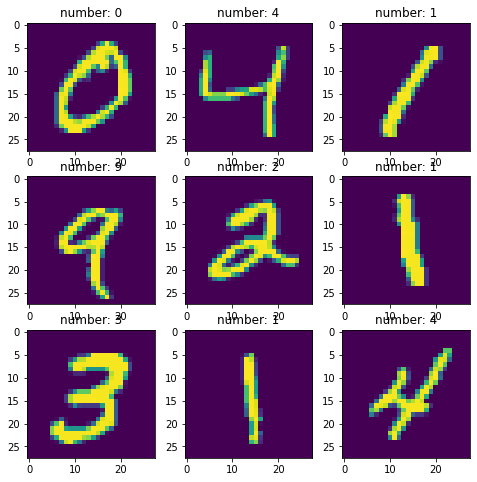

In [11]:
#Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print('train')
print(x_train.shape)
print(y_train.shape)
print(type(x_train))
print('test')
print(x_test.shape)
print(y_test.shape)

#Visualize with matplot lib 
fig = plt.figure(figsize=(8,8))

print('Training shape = ', x_train[0].shape)
print('X datatype= ', x_train[0].dtype)
print("Label shape = ", y_train[0].shape)
print('Y datatype = ', y_train[0].dtype)

for i in range(1, 10):
  plt.subplot(3,3,i)
  plt.imshow(x_train[i])
  plt.title(f'number: {y_train[i]}')

def process(x,y):
  #Rescale values to [0.0, 1.0] range
  #convert to float32 type
  x = x.astype('float32') / 255.
  #Reshape input to (1,28,28)
  x = x.reshape(len(x), 1,28,28)
  #Convert y to categorical label ( shape [2,1])
  y = tf.keras.utils.to_categorical(y)
  y = y.reshape(len(y), 10,1)
  return x,y

p_x_train, p_y_train = process(x_train, y_train)

print("\nAfter Processed")
print('Training shape = ', p_x_train[0].shape)
print('X datatype= ', p_x_train[0].dtype)
print("Label shape = ", p_y_train[0].shape)
print('Y datatype = ', p_y_train[0].dtype)
print(p_y_train[0])

p_x_test, p_y_test = process(x_test, y_test)


In [26]:
#Create a model and establish train precedure
input_shape = (1,28,28)
kernel_size = 3
depth = 5

#limit x and y to decrease execution time
# limit = 1000 
# p_x_train = p_x_train[:limit]
# p_y_train = p_y_train[:limit]

network = [
    Conv2D(input_shape, kernel_size, depth),
    Sigmoid(),
    Reshape((5,26,26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 10),
    Sigmoid()
]

epochs = 20
learning_rate = 0.01

#Train
print("Started training ... ")
for e in range(epochs):
  error = 0
  for x,y in zip(p_x_train, p_y_train):
    output = x
    for layer in network:
      #forward
      output = layer.forward(output)
    
    #error
    error += binary_cross_entropy(y, output)

    #backward
    grad = binary_cross_entropy_prime(y, output)

    for layer in reversed(network):
      grad = layer.backward(grad, learning_rate)
    
  error /= len(p_x_train)

  print(f'{e}/{epochs}: error = {error}')

print("Done training")




Started training ... 
0/20: error = 0.5045928558251493
1/20: error = 0.35076837688077545
2/20: error = 0.32914273025654917
3/20: error = 0.31635314439474077
4/20: error = 0.3062765925299428
5/20: error = 0.2993232988901931
6/20: error = 0.2940006525564338
7/20: error = 0.28928095696869094
8/20: error = 0.2848133725164257
9/20: error = 0.2803513104345568
10/20: error = 0.275897381008402
11/20: error = 0.27191026860243384
12/20: error = 0.2681318424907605
13/20: error = 0.263713957925836
14/20: error = 0.2587147547381107
15/20: error = 0.2544201450934098
16/20: error = 0.2506302136267381
17/20: error = 0.2472156321470118
18/20: error = 0.24405232500155905
19/20: error = 0.24101692654667917
Done training


In [27]:

def get_accuracy(x_test, y_test, network):
  correct = 0
  for x,y in zip(x_test, y_test):
    output = x
    for layer in network:
      output = layer.forward(output)
    if np.argmax(output) == np.argmax(y):
      correct+=1
  
  return correct / len(y_test)

accuracy = get_accuracy(p_x_test, p_y_test, network)
print(f'accuracy = ',accuracy)

accuracy =  0.456
